In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
# Load the dataset
heart_disease = pd.read_csv('data/heart.csv')
heart_disease.head()

### Data preprocessing

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Numerical transfomer pipeline
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

In [72]:
# Categorical transfomer pipeline
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

categorical_transofrmer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [73]:
# Data preprocessing

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transofrmer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

### Model Building

In [74]:
X = heart_disease.drop('target', axis=1)
y = heart_disease['target']

In [75]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

classification_models = {
        'Logistic Regression' : Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(max_iter=1000))
        ]),
        'RandomForestClassifier' : Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier())
        ]),
        'XGBoost' : Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier())
        ])
    }

results = {}

In [80]:
np.random.seed(42)

for model_name, model in classification_models.items():
    model.fit(X_train, y_train)
    results[model_name] = model.score(X_test, y_test)

results

/home/archlinux/Desktop/Projects/ML/SL/HeartDisease/testvenv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Logistic Regression': 0.8015564202334631,
 'RandomForestClassifier': 0.9766536964980544,
 'XGBoost': 0.9883268482490273}

<Axes: >

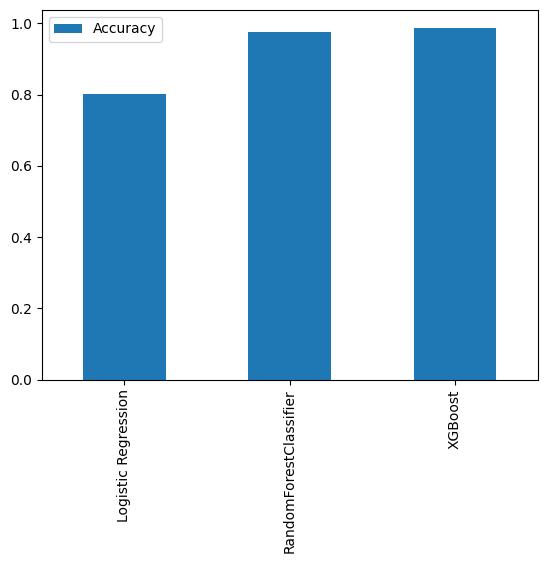

In [100]:
results_df = pd.DataFrame(results.values(),
                          results.keys(),
                          columns=['Accuracy'])
results_df.plot.bar()

# Notice that XGBoost scored the highest, with ~98.83% accuracy

### Hyperparameter tuning

In [101]:
# Logistic Regression hyperparamters
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

In [110]:
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(42)
# Instance of RandomizedSearchCV with a LogisticRegression() estimator

rs_log_reg = RandomizedSearchCV(estimator=LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=1000,
                                verbose=True)
# Fit the instance of RandomizedSearchCV
rs_log_reg.fit(X_train, y_train)

/home/archlinux/Desktop/Projects/ML/SL/HeartDisease/testvenv/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 20 is smaller than n_iter=1000. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


,estimator,LogisticRegression()
,param_distributions,"{'C': array([1.0000...00000000e+04]), 'solver': ['liblinear']}"
,n_iter,1000
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [111]:
# Best parameters of the RandomizedSearchCV instance
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': np.float64(11.288378916846883)}

In [112]:
rs_log_reg.score(X_test, y_test)

0.7937743190661478

In [113]:
# LogisticRegression classifier using the best hyperparameters from RandomizedSearchCV

clf = LogisticRegression(solver='liblinear', C=11.288378916846883)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7937743190661478

In [134]:
# Random Forest hyperparameters
from scipy.stats import randint
rf_param_grid = {
    'n_estimators' : [100, 200],
    'max_depth' : [None , 10, 20],
    'min_samples_split' : [2, 5],
    'min_samples_leaf' : [1, 2],
    'max_features' : ['sqrt', 'log2', None],
    'bootstrap' : [True, False]
}

In [135]:
rs_rf = RandomizedSearchCV(estimator=RandomForestClassifier(),
                                param_distributions=rf_param_grid,
                                cv=5,
                                n_iter=5,
                                verbose=True)
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


,estimator,RandomForestClassifier()
,param_distributions,"{'bootstrap': [True, False], 'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [1, 2], ...}"
,n_iter,5
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [136]:
rs_rf.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [138]:
rs_rf.score(X_test, y_test)

0.9883268482490273

In [140]:
# RandomForest Classifier using the best hyperparameters from RandomizedSearchCV

clf = RandomForestClassifier(n_estimators=100,
                             min_samples_split=5,
                             min_samples_leaf=1,
                             max_features='sqrt',
                             max_depth=10,
                             bootstrap=True)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9883268482490273